In [1]:
## Import Libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
## Using pandas, read html using the given url  

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

toronto_df=pd.read_html(url, header=0)
toronto_df[0].to_csv('toronto.csv',index=False)
toronto_data=pd.read_csv('toronto.csv')

print (toronto_data.shape)
toronto_data.head()


(180, 3)


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
## Remove rows with Borough == Not assigned

NABorough=toronto_data[toronto_data['Borough'] == 'Not assigned'].index
toronto_data.drop(NABorough, axis=0, inplace=True)
print(toronto_data.shape)
toronto_data.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
## Confirm there are no rows where Neighbourhood == Not assigned

NANeigh=toronto_data[toronto_data['Neighbourhood']=='Not assigned'].index
NANeigh.shape


(0,)

In [5]:
## install pgeocode to get latitudes and longitudes of postal codes
!pip install pgeocode
import pgeocode
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
postal_codes = toronto_data['Postal Code'].tolist()
latitudes = []
longitudes = []
print("pgeocode downloaded")

pgeocode downloaded


In [6]:
for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)


In [7]:
## check len of lists are the same before returning dataframe
print (len(postal_codes),len(latitudes),len(longitudes))

toronto_data['Neighbourhood Latitude']=latitudes
toronto_data['Neighbourhood Longitude']=longitudes
toronto_data.head()

103 103 103


,Postal Code,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude
2,M3A,North York,Parkwoods,43.7545,-79.3300
3,M4A,North York,Victoria Village,43.7276,-79.3148
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


In [8]:
## Drop NaN rows and reset index for GTA  
toronto_data.dropna(axis=0,inplace=True)
GTA = toronto_data.reset_index(drop=True)
print (GTA.shape)
GTA.head() 

(102, 5)


,Postal Code,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889


In [9]:
## Make a call to Foursquare API and define getNearbyVenues function 
CLIENT_ID = 'R12BNMHALD4Y5F1E5IWIA2YMYTTUZP4E0NZRUHVSMLA2WEIM' # your Foursquare ID
CLIENT_SECRET = 'UST5LXSGJNS0YH2ACP3JNUEIIUUIGOUONRC5VWZLZI5ZB3W0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## Define function to get venues

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [10]:
## explore venues within radius and up to LIMIT

GTA_venues = getNearbyVenues(names = GTA['Neighbourhood'], latitudes=GTA['Neighbourhood Latitude'], longitudes=GTA['Neighbourhood Longitude'])
print(GTA_venues.shape) 
GTA_venues.head()   

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7545,-79.3300,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.7545,-79.3300,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.7276,-79.3148,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.7276,-79.3148,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.7276,-79.3148,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [11]:
## Count number of unique venue categories

GTA_venues.groupby('Neighbourhood').count() 
print('There are {} unique categories.'.format(len(GTA_venues['Venue Category'].unique())))
                                                             
# Use one hot encoding to separate Venue Category 
GTA_onehot = pd.get_dummies(GTA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
GTA_onehot['Neighbourhood'] = GTA_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [GTA_onehot.columns[-1]] + list(GTA_onehot.columns[:-1])
GTA_onehot = GTA_onehot[fixed_columns]
print(GTA_onehot.shape)
GTA_onehot.head() 

There are 252 unique categories.
(2151, 253)


,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
GTA_onehot.columns

Index(['Neighbourhood', 'Accessories Store', 'Afghan Restaurant', 'Airport',
       'American Restaurant', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports',
       ...
       'Video Game Store', 'Video Store', 'Vietnamese Restaurant',
       'Warehouse Store', 'Whisky Bar', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio'],
      dtype='object', length=253)

In [17]:
## Group by neighborhood and return the mean per category 
GTA_grouped = GTA_onehot.groupby('Neighbourhood').mean().reset_index()
print (GTA_grouped.shape)  

## return top 10 most common venues per Neighborhood

num_top_venues = 10

for hood in GTA_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = GTA_grouped[GTA_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')   




(95, 253)
----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1                  Newsagent   0.2
2             Breakfast Spot   0.2
3            Badminton Court   0.2
4               Skating Rink   0.2
5        Monument / Landmark   0.0
6                     Museum   0.0
7              Moving Target   0.0
8              Movie Theater   0.0
9        Moroccan Restaurant   0.0


----Alderwood, Long Branch----
                             venue  freq
0                      Pizza Place  0.17
1                Convenience Store  0.17
2                              Gym  0.17
3                   Sandwich Place  0.17
4                              Pub  0.17
5                      Coffee Shop  0.17
6  Molecular Gastronomy Restaurant  0.00
7              Monument / Landmark  0.00
8              Moroccan Restaurant  0.00
9                     Neighborhood  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0         

                       venue  freq
0                   Pharmacy  0.33
1                       Bank  0.17
2                       Park  0.17
3              Grocery Store  0.17
4               Skating Rink  0.17
5         Mexican Restaurant  0.00
6  Middle Eastern Restaurant  0.00
7         Miscellaneous Shop  0.00
8          Mobile Phone Shop  0.00
9                Music Store  0.00


----Kennedy Park, Ionview, East Birchmount Park----
                venue  freq
0         Coffee Shop  0.21
1    Department Store  0.07
2          Hobby Shop  0.07
3      Sandwich Place  0.07
4  Light Rail Station  0.07
5         Bus Station  0.07
6                Bank  0.07
7   Convenience Store  0.07
8       Grocery Store  0.07
9            Bus Line  0.07


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                           Café  0.09
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3             Mexican Restaurant  0.06
4     

                venue  freq
0         Coffee Shop  0.07
1                Café  0.07
2  Seafood Restaurant  0.06
3        Cocktail Bar  0.03
4  Italian Restaurant  0.03
5           Gastropub  0.03
6               Hotel  0.02
7              Bakery  0.02
8      Clothing Store  0.02
9      Cosmetics Shop  0.02


----St. James Town, Cabbagetown----
                venue  freq
0         Coffee Shop  0.10
1          Restaurant  0.05
2              Bakery  0.05
3                Café  0.05
4  Italian Restaurant  0.05
5                Park  0.05
6         Pizza Place  0.05
7               Plaza  0.02
8    Sushi Restaurant  0.02
9           Gift Shop  0.02


----Steeles West, L'Amoreaux West----
                  venue  freq
0  Fast Food Restaurant  0.18
1           Pizza Place  0.09
2  Other Great Outdoors  0.09
3                  Bank  0.09
4        Sandwich Place  0.09
5    Chinese Restaurant  0.09
6           Supermarket  0.09
7        Discount Store  0.09
8              Pharmacy  0.09
9     

In [18]:
## select only the top venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Create a new dataframe to display the top 10 venues per Neighborhood, note indicator code

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
GTA_venues_sorted = pd.DataFrame(columns=columns)
GTA_venues_sorted['Neighbourhood'] = GTA_grouped['Neighbourhood']

for ind in np.arange(GTA_grouped.shape[0]):
    GTA_venues_sorted.iloc[ind, 1:] = return_most_common_venues(GTA_grouped.iloc[ind, :], num_top_venues)
print(GTA_venues.shape)
GTA_venues_sorted.head()  



(2151, 7)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Newsagent,Breakfast Spot,Skating Rink,Badminton Court,Latin American Restaurant
1,"Alderwood, Long Branch",Gym,Convenience Store,Pizza Place,Coffee Shop,Pub
2,"Bathurst Manor, Wilson Heights, Downsview North",Mediterranean Restaurant,Deli / Bodega,Coffee Shop,Grocery Store,Middle Eastern Restaurant
3,Bayview Village,Flower Shop,Park,Golf Driving Range,Dog Run,Trail
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Comfort Food Restaurant,Cosmetics Shop


In [88]:
## Run k-means clustering

kclusters = 10

GTA_grouped_clustering = GTA_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(GTA_grouped_clustering)

# check cluster labels generated for each row in the dataframe

kmeans.labels_[0:]  
  


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 7, 9, 9, 5, 1, 1, 1, 7, 1, 1,
       1, 1, 0, 1, 1, 6, 7, 1, 0, 0, 7, 1, 1, 7, 1, 1, 0, 1, 1, 1, 7, 1,
       1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2,
       3, 1, 1, 8, 7, 7, 1], dtype=int32)

In [90]:
# add clustering labels back by merging the array into the dataframe. If running second time, uncomment below:
GTA_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

Clabels=kmeans.labels_.astype('int')

GTA_venues_sorted.insert(0, 'Cluster Labels', Clabels)

GTA_merged = GTA

# merge GTA_venues_sorted with GTA to add latitude/longitude for each neighborhood
GTA_merged = GTA_merged.join(GTA_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

## Drop NaN rows and reset index for GTA_merged  
GTA_merged.dropna(axis=0,inplace=True)
GTA_filtered = GTA_merged.reset_index(drop=True)
print (GTA_filtered.shape)
GTA_filtered [ ['Cluster Labels'] ] = GTA_filtered [ ['Cluster Labels'] ].astype('int')
GTA_filtered.head(99) 




(99, 11)


,Postal Code,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.7545,-79.3300,0,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Flea Market
1,M4A,North York,Victoria Village,43.7276,-79.3148,1,French Restaurant,Hockey Arena,Park,Pizza Place,Financial or Legal Service
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,1,Coffee Shop,Breakfast Spot,Restaurant,Yoga Studio,Distribution Center
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,1,Clothing Store,Coffee Shop,Women's Store,Restaurant,Cosmetics Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,1,Sushi Restaurant,Gym,Italian Restaurant,Ramen Restaurant,Burrito Place
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.6662,-79.5282,7,Pharmacy,Skating Rink,Grocery Store,Bank,Park
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930,6,Home Service,Eastern European Restaurant,Flower Shop,Flea Market,Fish Market
7,M3B,North York,Don Mills,43.7450,-79.3590,0,Park,Gym,Trail,Pool,River
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094,1,Pizza Place,Pet Store,Gym / Fitness Center,Flea Market,Bank
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783,1,Coffee Shop,Clothing Store,Hotel,Japanese Restaurant,Café


In [91]:
# create map, clustering venues by category rather than location 

address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of GTA are {}, {}.'.format(latitude, longitude))  




The geographical coordinates of GTA are 43.6534817, -79.3839347.


In [92]:
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(GTA_filtered['Neighbourhood Latitude'], GTA_filtered['Neighbourhood Longitude'], GTA_filtered['Neighbourhood'], GTA_filtered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [265]:
# After inspection, we conclude that Cluster 0 have more Venues like Park, Gym, Pool, Yoga Studio within top 5 Venue.  
# These Other Venues appeal to health conscious customers which are target customers of Client V. 
# Cluster 0 also has no Vegetarian/Vegan restaurants that compete with Client V

GTA_Loc=GTA_filtered.loc[GTA_filtered['Cluster Labels'] == 0, GTA_filtered.columns[[0,1,2,3,4] + list(range(5, GTA_filtered.shape[1]))]] 
print(GTA_Loc.shape)
GTA_Loc


(8, 11)


,Postal Code,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.7545,-79.3300,0,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Flea Market
7,M3B,North York,Don Mills,43.7450,-79.3590,0,Park,Gym,Trail,Pool,River
12,M3C,North York,Don Mills,43.7334,-79.3329,0,Park,Gym,Trail,Pool,River
20,M6E,York,Caledonia-Fairbanks,43.6889,-79.4507,0,Park,Mexican Restaurant,Women's Store,Bakery,Sporting Goods Shop
48,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.7137,-79.4869,0,Bakery,Basketball Court,Electronics Store,Food & Drink Shop,Flower Shop
60,M4N,Central Toronto,Lawrence Park,43.7301,-79.3935,0,Photography Studio,Park,Eastern European Restaurant,Flower Shop,Flea Market
66,M4P,Central Toronto,Davisville North,43.7135,-79.3887,0,Food & Drink Shop,Breakfast Spot,Park,Department Store,Dog Run
81,M4T,Central Toronto,"Moore Park, Summerhill East",43.6899,-79.3853,0,Gym,Park,Playground,Thai Restaurant,Grocery Store


In [266]:
## We extract list of Postal Codes into new dataframe, and use it to scrape data from housepricehub.com

GTA_LocPC= pd.DataFrame(GTA_Loc['Postal Code'])

GTA_LocPC= GTA_LocPC.reset_index(drop=True)

# GTA_ListPC=GTA_LocPC.style.hide_index()


GTA_LocPC

,Postal Code
0,M3A
1,M3B
2,M3C
3,M6E
4,M6L
5,M4N
6,M4P
7,M4T


In [267]:
## From housepricehub.com, we get housing prices for each Postal Code using the given url  

url0='https://housepricehub.com/areas/area/M3A'
url1='https://housepricehub.com/areas/area/M3B'
url2='https://housepricehub.com/areas/area/M3C'
url3='https://housepricehub.com/areas/area/M6E'
url4='https://housepricehub.com/areas/area/M6L'
url5='https://housepricehub.com/areas/area/M4N'
url6='https://housepricehub.com/areas/area/M4P'
url7='https://housepricehub.com/areas/area/M4T'


In [268]:
## To define function that iterates through n=(0,7)

AHP0Data=pd.read_html(url0, header=0)
AHP0List=AHP0Data[0]
AHP0Price=AHP0List['Price']
AHP0nprice=pd.to_numeric(AHP0Price.replace("[^0-9\.-]", '', regex=True))
Mean0=AHP0nprice.mean()
print("M3A mean is:", Mean0)

AHP1Data=pd.read_html(url1,header=0)
AHP1List=AHP1Data[0]
AHP1Price=AHP1List['Price']
AHP1nprice=pd.to_numeric(AHP1Price.replace("[^0-9\.-]", '', regex=True))
Mean1=AHP1nprice.mean()
print("M3B mean is:",Mean1)

AHP2Data=pd.read_html(url2,header=0)
AHP2List=AHP2Data[0]
AHP2Price=AHP2List['Price']
AHP2nprice=pd.to_numeric(AHP2Price.replace("[^0-9\.-]", '', regex=True))
Mean2=AHP2nprice.mean()
print("M3C mean is:", Mean2)

AHP3Data=pd.read_html(url3,header=0)
AHP3List=AHP3Data[0]
AHP3Price=AHP3List['Price']
AHP3nprice=pd.to_numeric(AHP3Price.replace("[^0-9\.-]", '', regex=True))
Mean3=AHP3nprice.mean()
print("M6E mean is:", Mean3)

AHP4Data=pd.read_html(url4,header=0)
AHP4List=AHP4Data[0]
AHP4Price=AHP4List['Price']
AHP4nprice=pd.to_numeric(AHP4Price.replace("[^0-9\.-]", '', regex=True))
Mean4=AHP4nprice.mean()
print("M6L mean is:", Mean4)

AHP5Data=pd.read_html(url5,header=0)
AHP5List=AHP5Data[0]
AHP5Price=AHP5List['Price']
AHP5nprice=pd.to_numeric(AHP5Price.replace("[^0-9\.-]", '', regex=True))
Mean5=AHP5nprice.mean()
print("M4N mean is:", Mean5)

AHP6Data=pd.read_html(url6,header=0)
AHP6List=AHP6Data[0]
AHP6Price=AHP6List['Price']
AHP6nprice=pd.to_numeric(AHP6Price.replace("[^0-9\.-]", '', regex=True))
Mean6=AHP6nprice.mean()
print("M4P mean is:", Mean6)

AHP7Data=pd.read_html(url7,header=0)
AHP7List=AHP7Data[0]
AHP7Price=AHP7List['Price']
AHP7nprice=pd.to_numeric(AHP7Price.replace("[^0-9\.-]", '', regex=True))
Mean7=AHP7nprice.mean()
print("M4T mean is:", Mean7)

print("All Average House Prices returned")

M3A mean is: 1324613.1648044693
M3B mean is: 3281967.2813559324
M3C mean is: 3866780.54
M6E mean is: 950508.1202380953
M6L mean is: 1120455.3122529644
M4N mean is: 3406210.948924731
M4P mean is: 1840344.1
M4T mean is: 2763353.832167832
All Average House Prices returned


In [270]:
## Append Average House Prices back to GTA_Loc
AHPMeans=[Mean0,Mean1,Mean2,Mean3,Mean4,Mean5,Mean6,Mean7]
## Uncomment if running a second time 
## GTA_Loc=GTA_Loc.drop(['AvHsePr'], axis=1, inplace=True)

GTA_Loc.insert(0,'AvHsePr',AHPMeans)
GTA_Loc.head(8)


,AvHsePr,Postal Code,Borough,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1.324613e+06,M3A,North York,Parkwoods,43.7545,-79.3300,0,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Flea Market
7,3.281967e+06,M3B,North York,Don Mills,43.7450,-79.3590,0,Park,Gym,Trail,Pool,River
12,3.866781e+06,M3C,North York,Don Mills,43.7334,-79.3329,0,Park,Gym,Trail,Pool,River
20,9.505081e+05,M6E,York,Caledonia-Fairbanks,43.6889,-79.4507,0,Park,Mexican Restaurant,Women's Store,Bakery,Sporting Goods Shop
48,1.120455e+06,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.7137,-79.4869,0,Bakery,Basketball Court,Electronics Store,Food & Drink Shop,Flower Shop
60,3.406211e+06,M4N,Central Toronto,Lawrence Park,43.7301,-79.3935,0,Photography Studio,Park,Eastern European Restaurant,Flower Shop,Flea Market
66,1.840344e+06,M4P,Central Toronto,Davisville North,43.7135,-79.3887,0,Food & Drink Shop,Breakfast Spot,Park,Department Store,Dog Run
81,2.763354e+06,M4T,Central Toronto,"Moore Park, Summerhill East",43.6899,-79.3853,0,Gym,Park,Playground,Thai Restaurant,Grocery Store


(140,)


Text(0.5, 1.0, 'AvHsePr for M4P')

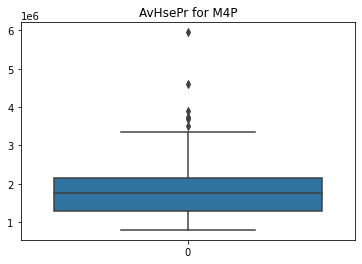

In [271]:
## Disregarding the 3 highest (due to zoning restrictions for high-end neighbourhoods) and 3 lowest (below target price-point for Client V), we use boxplots to examine the two remaining Postal Codes M4P and M4T
sns.boxplot(data=AHP6nprice)
print(AHP6nprice.shape)
plt.title('AvHsePr for M4P')

(143,)


Text(0.5, 1.0, 'AvHsePr for M4T')

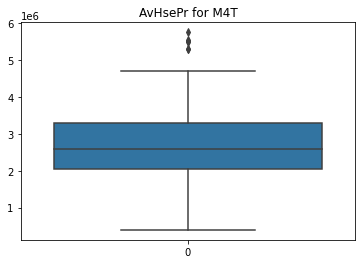

In [272]:
sns.boxplot(data=AHP7nprice)
print(AHP7nprice.shape)
plt.title('AvHsePr for M4T')

In [2]:

## Both Locations have fairly large samples sizes (>100), above average AHP with a broad interquartile range and few outliers. There should a fairly broad spectrum of customers for Client V.
print("Client V, we recommend these Locations to you in Central Toronto:","M4P and M4T\n")
print("End of Part 1 - Location")

Client V, we recommend these Locations to you in Central Toronto: M4P and M4T

End of Part 1 - Location
